
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [54]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs_fake = tf.placeholder(tf.float32, [None], name='targetQs_fake')
    targetQs_real = tf.placeholder(tf.float32, [None], name='targetQs_real')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs_fake, targetQs_real

In [55]:
# G: Generator/Encoder-Decoder/Predictor/Qfunction: given states, generate/predict the action and next state
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        # states sigmoid/regression/continuous and actions softmax/classification/discrete
        # Split states and actions together
        logits = tf.layers.dense(inputs=nl2, units=(state_size + action_size))        
        next_states_logits, actions_logit = tf.split(axis=1, num_or_size_splits=[state_size, action_size], 
                                                     value=logits)
        #predictions = tf.sigmoid(next_states_logits)
        #predictions = tf.nn.softmax(actions_logit)

        
        # return next_states_logits
        return next_states_logits, actions_logit

In [56]:
# D: Descriminator/Reward function
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fuse/merge states and actions together
        x_fused = tf.concat(axis=1, values=[states, actions])

        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return rewards logits
        return logits

In [57]:
def model_output(states, actions, next_states,
                 state_size, action_size, hidden_size):
    # GAN: Generate next states and current actions
    next_states_logits, actions_logits = generator(states=states, 
                                                   action_size=action_size, state_size=state_size, 
                                                   hidden_size=hidden_size)
    
    # Qs for the next states fake or real
    actions_real = tf.one_hot(depth=action_size, indices=actions)
    nextQs_logits_real = discriminator(states=next_states, actions=actions_real, hidden_size=hidden_size, 
                                       reuse=False)
    nextQs_logits_fake = discriminator(states=next_states_logits, actions=actions_logits, hidden_size=hidden_size, 
                                       reuse=True)
    
    # nextQs will be used outside
    return actions_logits, actions_real, nextQs_logits_fake, nextQs_logits_real

In [68]:
def model_loss(actions_logits, actions_real, targetQs_fake, targetQs_real):
    
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    g_loss = tf.reduce_mean(tf.square(targetQs_fake - Qs))
    d_loss = tf.reduce_mean(tf.square(targetQs_real - Qs))

    return g_loss, d_loss

In [69]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator/Decoder loss Tensor for next state and action prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [70]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs_fake, self.targetQs_real = model_input(
            state_size=state_size)

        # Output of the Model: forwad pass
        self.actions_logits, self.actions_real, self.nextQs_logits_fake, self.nextQs_logits_real = model_output(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # init data
            states=self.states, next_states=self.next_states, actions=self.actions) # model data
        
        # Loss of the Model: calculating the loss and forwad pass
        self.g_loss, self.d_loss = model_loss(
            actions_logits=self.actions_logits, actions_real=self.actions_real, 
            targetQs_fake=self.nextQs_logits_fake, targetQs_real=self.nextQs_logits_real)

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [71]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [72]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [73]:
train_episodes = 500           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [74]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [75]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list, d_loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss, d_loss = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Next action logits using next states for calculating maxQ
            #feed_dict={model.states: next_states}
            #next_actions_logits = sess.run(model.actions_logits, feed_dict)
            feed_dict = {model.states: states, 
                         model.actions: actions,
                         model.next_states: next_states} 
            nextQs_logits_fake, nextQs_logits_real = sess.run([model.nextQs_logits_fake, model.nextQs_logits_real], 
                                                              feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == tf.zeros(states[0].shape)).all(axis=1)
            #next_actions_logits[episode_ends] = (0, 0) # NOTE: action size
            nextQs_logits_fake[episode_ends] = 0 # NOTE: size is always one
            nextQs_logits_real[episode_ends] = 0 # NOTE: size is always one

            # Bellman equation: Qt = Rt + max(Qt+1)
            #targetQs = rewards + (gamma * np.max(next_actions_logits, axis=1))
            targetQs_fake = rewards + (gamma * nextQs_logits_fake)
            targetQs_real = rewards + (gamma * nextQs_logits_real)
            #targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            #targetQs = rewards_real.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            #targetQs = np.ones_like(rewards) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, 
                         model.actions: actions,
                         model.next_states: next_states, 
                         model.targetQs_fake: targetQs_fake,
                         model.targetQs_real: targetQs_real}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 3.0 Average reward fake: 0.504061758518219 Average reward real: 0.5252454280853271 Training g_loss: 1.7741 Training d_loss: 1.3504 Explore P: 0.9997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 12.0 Average reward fake: 0.4812980890274048 Average reward real: 0.5627188682556152 Training g_loss: 1.9413 Training d_loss: 1.2453 Explore P: 0.9985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 23.0 Average reward fake: 0.4685312509536743 Average reward real: 0.5662208795547485 Training g_loss: 2.3828 Training d_loss: 1.2540 Explore P: 0.9962
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 26 Total reward: 16.0 Average reward fake: 0.4905170500278473 Average reward real: 0.46737658977508545 Training g_loss: 64.0630 Training d_loss: 1.4487 Explore P: 0.9396
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 27 Total reward: 26.0 Average reward fake: 0.4837898910045624 Average reward real: 0.4778634011745453 Training g_loss: 49.4698 Training d_loss: 1.4159 Explore P: 0.9372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 28 Total reward: 52.0 Average reward fake: 0.5403423309326172 Average reward real: 0.5315186381340027 Training g_loss: 34.4244 Training d_loss: 1.4553 Explore P: 0.9324
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 51 Total reward: 39.0 Average reward fake: 0.4128710925579071 Average reward real: 0.535453200340271 Training g_loss: 637.1757 Training d_loss: 1.1917 Explore P: 0.8831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 52 Total reward: 17.0 Average reward fake: 0.43257826566696167 Average reward real: 0.5736687183380127 Training g_loss: 1496.3032 Training d_loss: 1.1197 Explore P: 0.8816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 53 Total reward: 15.0 Average reward fake: 0.40135669708251953 Average reward real: 0.5916107892990112 Training g_loss: 883.1275 Training d_loss: 1.1589 Explore P: 0.8803
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 76 Total reward: 34.0 Average reward fake: 0.020815158262848854 Average reward real: 0.91666579246521 Training g_loss: 48573.2812 Training d_loss: 0.1924 Explore P: 0.8016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 77 Total reward: 15.0 Average reward fake: 0.0009400920826010406 Average reward real: 0.8958086967468262 Training g_loss: 42144.1211 Training d_loss: 0.1682 Explore P: 0.8004
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 78 Total reward: 38.0 Average reward fake: 0.018426787108182907 Average reward real: 0.9094674587249756 Training g_loss: 88003.0156 Training d_loss: 0.1683 Explore P: 0.7974
----------------------------------------------------

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 16.0 Average reward fake: 0.004105728585273027 Average reward real: 0.9893536567687988 Training g_loss: 1557873.2500 Training d_loss: 0.1286 Explore P: 0.7334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 11.0 Average reward fake: 0.00040971313137561083 Average reward real: 0.9914528131484985 Training g_loss: 2921134.2500 Training d_loss: 0.0099 Explore P: 0.7326
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 30.0 Average reward fake: 0.054308243095874786 Average reward real: 0.9906358122825623 Training g_loss: 1720545.5000 Tr

-------------------------------------------------------------------------------
Episode: 125 Total reward: 152.0 Average reward fake: 2.260291703316462e-20 Average reward real: 0.9995169639587402 Training g_loss: 71977096.0000 Training d_loss: 0.0005 Explore P: 0.6209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 126 Total reward: 137.0 Average reward fake: 6.576804806071152e-21 Average reward real: 0.9998161196708679 Training g_loss: 104199848.0000 Training d_loss: 0.0002 Explore P: 0.6126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 127 Total reward: 44.0 Average reward fake: 6.010515767221838e-22 Average reward real: 0.9998295307159424 Training g_loss: 181903888.0000 Training d_loss: 0.0002 Explore P: 0.6100
--------------------------------

-------------------------------------------------------------------------------
Episode: 149 Total reward: 184.0 Average reward fake: 6.045371649427901e-24 Average reward real: 0.999992847442627 Training g_loss: 1847822080.0000 Training d_loss: 0.0000 Explore P: 0.4805
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 150 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9999856352806091 Training g_loss: 1357165312.0000 Training d_loss: 0.0000 Explore P: 0.4712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 151 Total reward: 50.0 Average reward fake: 0.0 Average reward real: 0.9999929070472717 Training g_loss: 2329537280.0000 Training d_loss: 0.0000 Explore P: 0.4689
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 174 Total reward: 199.0 Average reward fake: 1.1505434638192986e-17 Average reward real: 0.9999401569366455 Training g_loss: 2431164928.0000 Training d_loss: 0.0001 Explore P: 0.3226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 175 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9999978542327881 Training g_loss: 2933393408.0000 Training d_loss: 0.0000 Explore P: 0.3164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9999896883964539 Training g_loss: 2608679168.0000 Training d_loss: 0.0000 Explore P: 0.3104
--------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 198 Total reward: 199.0 Average reward fake: 2.5395619965081514e-39 Average reward real: 1.0 Training g_loss: 263604816.0000 Training d_loss: 0.0000 Explore P: 0.2039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 199 Total reward: 199.0 Average reward fake: 1.3303275005845019e-15 Average reward real: 0.9999999403953552 Training g_loss: 287456608.0000 Training d_loss: 0.0000 Explore P: 0.2001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9999702572822571 Training g_loss: 401182016.0000 Training d_loss: 0.0000 Explore P: 0.1963
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 222 Total reward: 146.0 Average reward fake: 2.7882871063711333e-21 Average reward real: 0.9999826550483704 Training g_loss: 65354936.0000 Training d_loss: 0.0000 Explore P: 0.1325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 223 Total reward: 77.0 Average reward fake: 8.319244598764541e-12 Average reward real: 0.9999909996986389 Training g_loss: 65393504.0000 Training d_loss: 0.0000 Explore P: 0.1315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 224 Total reward: 199.0 Average reward fake: 1.4814450111089172e-08 Average reward real: 0.9999191164970398 Training g_loss: 16966074.0000 Training d_loss: 0.0001 Explore P: 0.1291
--------------------------------

-------------------------------------------------------------------------------
Episode: 246 Total reward: 199.0 Average reward fake: 2.654518792277738e-11 Average reward real: 0.9876434206962585 Training g_loss: 21712140.0000 Training d_loss: 0.0171 Explore P: 0.0879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 140.0 Average reward fake: 3.408518606251576e-11 Average reward real: 0.9956371188163757 Training g_loss: 3733689.7500 Training d_loss: 0.0054 Explore P: 0.0869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 248 Total reward: 199.0 Average reward fake: 8.499279838952711e-13 Average reward real: 0.9997544884681702 Training g_loss: 2823684.0000 Training d_loss: 0.0002 Explore P: 0.0853
-----------------------------------

-------------------------------------------------------------------------------
Episode: 270 Total reward: 199.0 Average reward fake: 1.5690894041638032e-24 Average reward real: 0.9998789429664612 Training g_loss: 6143979.5000 Training d_loss: 0.0001 Explore P: 0.0603
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 271 Total reward: 199.0 Average reward fake: 3.29162692188585e-32 Average reward real: 0.999864935874939 Training g_loss: 3869640.5000 Training d_loss: 0.0001 Explore P: 0.0594
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 272 Total reward: 199.0 Average reward fake: 3.271597576182117e-11 Average reward real: 0.999845027923584 Training g_loss: 6557003.5000 Training d_loss: 0.0002 Explore P: 0.0584
--------------------------------------

-------------------------------------------------------------------------------
Episode: 294 Total reward: 189.0 Average reward fake: 6.485138328571338e-07 Average reward real: 0.9876596927642822 Training g_loss: 613133.5625 Training d_loss: 0.0799 Explore P: 0.0433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 295 Total reward: 199.0 Average reward fake: 2.2583002904762867e-13 Average reward real: 0.994875967502594 Training g_loss: 505877.0625 Training d_loss: 0.0059 Explore P: 0.0427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 296 Total reward: 199.0 Average reward fake: 0.01188679225742817 Average reward real: 0.9979493618011475 Training g_loss: 414750.0938 Training d_loss: 0.0021 Explore P: 0.0420
-----------------------------------------

-------------------------------------------------------------------------------
Episode: 318 Total reward: 199.0 Average reward fake: 8.048463482731838e-20 Average reward real: 0.9993737936019897 Training g_loss: 697260.3750 Training d_loss: 0.0235 Explore P: 0.0316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 319 Total reward: 199.0 Average reward fake: 0.013803798705339432 Average reward real: 0.9945088028907776 Training g_loss: 464343.6562 Training d_loss: 0.0913 Explore P: 0.0311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 320 Total reward: 173.0 Average reward fake: 8.795093435765011e-07 Average reward real: 0.9987977743148804 Training g_loss: 331055.9375 Training d_loss: 0.0012 Explore P: 0.0308
----------------------------------------

-------------------------------------------------------------------------------
Episode: 342 Total reward: 21.0 Average reward fake: 0.0 Average reward real: 0.9997305274009705 Training g_loss: 331423.5938 Training d_loss: 0.0003 Explore P: 0.0257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 343 Total reward: 13.0 Average reward fake: 0.0 Average reward real: 0.9993737936019897 Training g_loss: 10528414.0000 Training d_loss: 0.0006 Explore P: 0.0257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 181.0 Average reward fake: 0.0 Average reward real: 0.9998090863227844 Training g_loss: 589198.6250 Training d_loss: 0.0002 Explore P: 0.0254
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 367 Total reward: 199.0 Average reward fake: 2.3138438387526605e-10 Average reward real: 0.9951484203338623 Training g_loss: 134917.1250 Training d_loss: 0.0068 Explore P: 0.0204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 130.0 Average reward fake: 0.0 Average reward real: 0.9982867240905762 Training g_loss: 1459088.6250 Training d_loss: 0.0017 Explore P: 0.0203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 199.0 Average reward fake: 0.049697838723659515 Average reward real: 0.9995476603507996 Training g_loss: 496725.3750 Training d_loss: 0.0005 Explore P: 0.0201
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 392 Total reward: 11.0 Average reward fake: 0.0 Average reward real: 0.9981220364570618 Training g_loss: 1844674.0000 Training d_loss: 0.0019 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 118.0 Average reward fake: 0.0 Average reward real: 0.9995100498199463 Training g_loss: 702862.3125 Training d_loss: 0.0005 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 199.0 Average reward fake: 1.202590246987564e-16 Average reward real: 0.9993617534637451 Training g_loss: 4035382.2500 Training d_loss: 0.0006 Explore P: 0.0179
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 417 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9991947412490845 Training g_loss: 93218.7891 Training d_loss: 0.0008 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9984330534934998 Training g_loss: 483220.7812 Training d_loss: 0.0016 Explore P: 0.0153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 199.0 Average reward fake: 2.9834922387130013e-16 Average reward real: 0.9990790486335754 Training g_loss: 290679.5000 Training d_loss: 0.0009 Explore P: 0.0152
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 442 Total reward: 199.0 Average reward fake: 1.3254880699975491e-11 Average reward real: 0.9966192841529846 Training g_loss: 145415.1875 Training d_loss: 0.0034 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 443 Total reward: 113.0 Average reward fake: 0.0 Average reward real: 0.9972506761550903 Training g_loss: 349276.5938 Training d_loss: 0.0028 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 91.0 Average reward fake: 0.0 Average reward real: 0.998464822769165 Training g_loss: 601018.6250 Training d_loss: 0.0015 Explore P: 0.0134
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 467 Total reward: 116.0 Average reward fake: 0.0 Average reward real: 0.9992722868919373 Training g_loss: 29667.2969 Training d_loss: 0.0007 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 104.0 Average reward fake: 1.799665375380101e-29 Average reward real: 0.9997192621231079 Training g_loss: 72456.7344 Training d_loss: 0.0003 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 99.0 Average reward fake: 0.00466429628431797 Average reward real: 0.9983218908309937 Training g_loss: 131248.1875 Training d_loss: 0.0017 Explore P: 0.0123
--------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 492 Total reward: 105.0 Average reward fake: 1.734946509396228e-21 Average reward real: 0.9901478290557861 Training g_loss: 306006.9375 Training d_loss: 0.0128 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9985133409500122 Training g_loss: 435019.7188 Training d_loss: 0.0015 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 494 Total reward: 119.0 Average reward fake: 0.0 Average reward real: 0.9977642297744751 Training g_loss: 70875.5391 Training d_loss: 0.0023 Explore P: 0.0117
----------------------------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

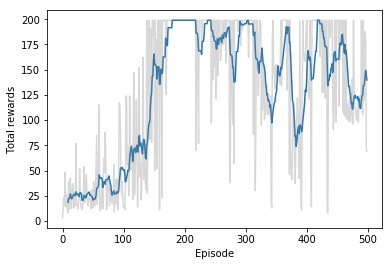

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

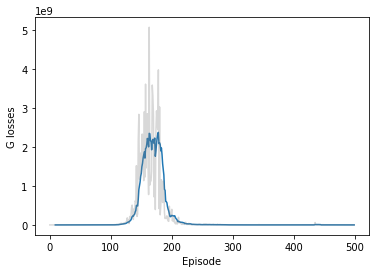

In [22]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

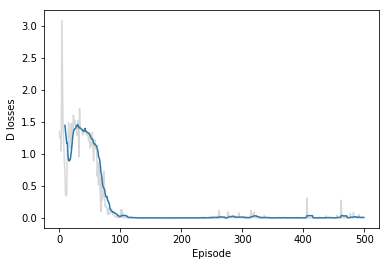

In [23]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.